## DNN vs LSTM

This notebook mainly compares a DNN (1 layer) vs an LSTM for determining whether an article is clickbait from its title. We balance out the instances in each class as well.

Here, we use oversampling of the minority class (clickbait).

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Input, Embedding, LSTM, Dropout, BatchNormalization, GRU
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.model_selection import train_test_split

from small_dataset import get_small_dataset
from large_dataset_title import get_large_dataset

from collections import Counter

Using TensorFlow backend.
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtype

## Preliminaries

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def print_cm(y_test, y_pred):
    y_test = np.array(y_test)

    y_pred_output = np.array([1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))])
    cm = confusion_matrix(y_test, y_pred_output)

    class_names = ["nonclickbait", "clickbait"]
    plot_confusion_matrix(y_test, y_pred_output, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred_output, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [4]:
# preprocess text to remove redundant things
# courtesy of https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
import re

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [5]:
"""
Code courtesy of https://keras.io/examples/pretrained_word_embeddings/
Inspiration also from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
"""
# load glove embeddings - only need to be run once
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
EMBEDDING_DIM = 100  # because using glove.6B.100

# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_dictionary = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_dictionary[word] = coefs

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


In [6]:
def plot_loss_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

## Using normal deep neural network (1 dense layer)

In [7]:
# get dataset
df = get_large_dataset()
df["title"][5]

'World Anti-Doping Agency lifts ban on Madrid laboratory'

In [8]:
X = df["title"]
y = df["label"]
y = [1 if y[i] == '1' else 0 for i in range(len(y))]

print('dataset shape %s' % sorted(Counter(y).items()))

dataset shape [(0, 14777), (1, 4761)]


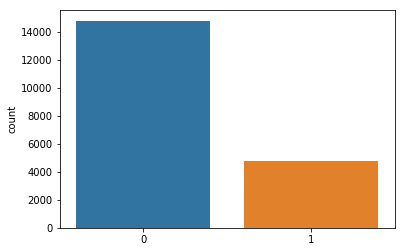

In [9]:
# visualise number of instances of each label
import seaborn as sns

sns.countplot(y)

In [10]:
print(X[99])
X_processed = [preprocess_text(X[i]) for i in range(len(X))]
print(X_processed[99])

Melissa Etheridge: ‘I’d Much Rather Have a Smoke With My Grown Kids Than a Drink’ [Video]
Melissa Etheridge d Much Rather Have Smoke With My Grown Kids Than Drink Video 


In [11]:
# split dataset into train and test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_processed, y, test_size=0.20, random_state=42)

In [12]:
# oversample X_train and y_train
# oversample minority instances (clickbait) to equalise number of instances

print('Original dataset shape %s' % Counter(y))
ros = RandomOverSampler(random_state=0)
X_train_temp2 = np.asarray(X_train_temp)
X_reshaped = X_train_temp2.reshape(-1, 1)
X_train, y_train = ros.fit_resample(X_reshaped, y_train_temp)

Original dataset shape Counter({0: 14777, 1: 4761})


In [15]:
# create a word-to-index dictionary
MAX_NUM_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
X_train_list = [X_train[i][0] for i in range(len(X_train))]
tokenizer.fit_on_texts(X_train_list)

X_train_tok = tokenizer.texts_to_sequences(X_train_list)
X_test_tok = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19246 unique tokens.


In [16]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_padded = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

print('Shape of data tensor:', X_train_padded.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (23650, 100)
Shape of label tensor: (23650,)


In [17]:
# create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
# set up models
dropout = 0.5
dropout_embedding = 0.2
learning_rate = 1e-5

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(128, batch_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = Adam(lr=1e-5)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1924700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,205,469
Tr

In [19]:
### Create model checkpoint
output_dir = os.getcwd()
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/DNN_oversampledafter.{epoch:02d}-{val_loss:.2f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint]#, EarlyStopping(monitor = "val_loss", patience = 15)]

In [20]:
#Hyper-Params
epochs = 100
batch_size = 32

# train model
history = model.fit(X_train_padded, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=callbacks_list)


Train on 18920 samples, validate on 4730 samples
Epoch 1/100
18920/18920 [==============================] - 11s 566us/step - loss: 0.7887 - accuracy: 0.5561 - val_loss: 0.5013 - val_accuracy: 0.7789

Epoch 00001: val_loss improved from inf to 0.50126, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNN_oversampledafter.01-0.50.hdf5
Epoch 2/100
18920/18920 [==============================] - 10s 550us/step - loss: 0.7230 - accuracy: 0.5992 - val_loss: 0.4937 - val_accuracy: 0.7767

Epoch 00002: val_loss improved from 0.50126 to 0.49369, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNN_oversampledafter.02-0.49.hdf5
Epoch 3/100
18920/18920 [==============================] - 10s 518us/step - loss: 0.6787 - accuracy: 0.6292 - val_loss: 0.4915 - val_accuracy: 0.7700

Epoch 00003: val_loss improved from 0.49369 to 0.49149, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNN_oversampledafter.03-0

18920/18920 [==============================] - 16s 865us/step - loss: 0.5036 - accuracy: 0.7496 - val_loss: 0.4646 - val_accuracy: 0.7854

Epoch 00038: val_loss improved from 0.46731 to 0.46458, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNN_oversampledafter.38-0.46.hdf5
Epoch 39/100
18920/18920 [==============================] - 13s 670us/step - loss: 0.4992 - accuracy: 0.7554 - val_loss: 0.4918 - val_accuracy: 0.7567

Epoch 00039: val_loss did not improve from 0.46458
Epoch 40/100
18920/18920 [==============================] - 12s 616us/step - loss: 0.5004 - accuracy: 0.7539 - val_loss: 0.4800 - val_accuracy: 0.7719

Epoch 00040: val_loss did not improve from 0.46458
Epoch 41/100
18920/18920 [==============================] - 12s 649us/step - loss: 0.4991 - accuracy: 0.7558 - val_loss: 0.4976 - val_accuracy: 0.7556

Epoch 00041: val_loss did not improve from 0.46458
Epoch 42/100
18920/18920 [==============================] - 14s 714us/step - loss:

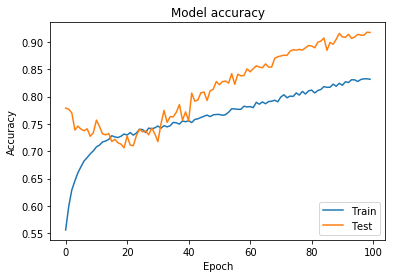

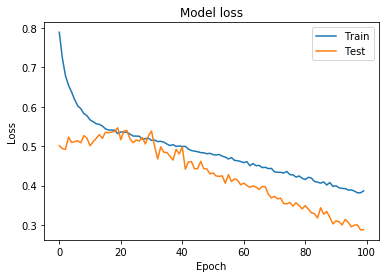

In [21]:
plot_loss_accuracy(history)

In [22]:
print(model.metrics_names)
model.evaluate(X_test_padded, y_test)

['loss', 'accuracy']
3908/3908 [==============================] - 0s 88us/step


[0.5721744459995594, 0.7141760587692261]

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
y_pred = model.predict(X_test_padded, verbose=1)

3908/3908 [==============================] - 1s 136us/step


In [28]:
y_pred_output = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]

F1 score: 0.49019
Confusion matrix, without normalization
[[2254  698]
 [ 419  537]]
Normalized confusion matrix
[[0.76355014 0.23644986]
 [0.43828452 0.56171548]]


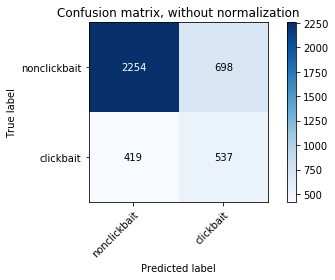

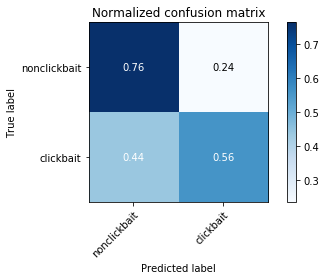

In [32]:
from sklearn.metrics import f1_score
print("F1 score: %3.5f" % f1_score(y_test, y_pred_output))
print_cm(y_test, y_pred)

In [29]:
# determine false positives and false negatives
# false positives - actual=0, pred=1
false_positive_instances = []
for i in range(len(y_pred_output)):
    if y_pred_output[i] == 1 \
    and y_test[i] == 0:
        false_positive_instances.append(X_test[i])
        
print("number of false positives: %d" % len(false_positive_instances))
print(false_positive_instances)

number of false positives: 698
[' Ways to Ditch Dull Dry Skin This Winter', 'At This Kolkata Market You Can Sell Your Demonetised Rupee Note For Rs ', 'Couples Ringing in the New Year', 'A California waiter refused to serve Latina women until he saw proof of residency ', 'Research shows young girls are less likely to think of women as really really smart ', 'Students Wear White Pins as Reminder to Check Their White Privilege', 'Peace in Cyprus is possible We Cypriots just have to decide to want it', 'School Suspends Year Old Boy Attacked on Bus for Wearing Make America Great Again Hat', 'Yale University college honouring slave advocate renamed for pioneering woman scientist', 'Indian Students Think Twice About Attending S Universities', ' NBA Superstar Rankings Giannis Antetokounmpo Keeps Soaring', 'Yes it snows in Hawaii More than feet of snow in forecast', 'Are You Attending the Women March on Washington ', 'More than percent of world coral reefs will die by ', 'The US Music Industry

In [30]:
# false negatives - actual=1, pred=0
false_negative_instances = []
for i in range(len(y_pred_output)):
    if y_pred_output[i] == 0 \
    and y_test[i] == 1:
        false_negative_instances.append(X_test[i])
        
print("number of false negatives: %d" % len(false_negative_instances))
print(false_negative_instances)

number of false negatives: 419
['Pair Of Google Home Devices Claim They re Human Quote Nickelback', 'Executive Edge', 'Jon Jones Offers Ronda Rousey Career Advice Following Her Loss', 'Police decide man touching woman thigh on bus wasn harassment for ridiculous reason', 'MSNBC Ruhle Conway Did Break the Glass Ceiling ', 'Brent Musburger Olbermann Should Stick to Sports', 'Former Clinton Campaign Adviser Trump Is Dystopian Super Villain ', 'Poll Democratic Women Most Likely to Block or Unfriend Someone over Politics', 'Trump Blistering Speech at CPAC Follows Bannon Blueprint ', 'Michael Sheen Leaving Hollywood to Fight Rise of Populism Update ', 'Cavaliers LeBron James weighs in on NBA rest conundrum', 'Shahid Mira Cute Banter Dangal National Anthem Leaves Twitterati In Fix More From Ent ', 'Gujarat Boy Who Went Missing During Earthquake Returns Years Later As Monk', 'US truck driver loses his marbles on Indiana highway', 'Four Killed Injured in Jerusalem Truck Ramming Terror Attack', '

## Using LSTMs

In [ ]:
# get dataset
df1 = get_large_dataset()

In [ ]:
X1 = df1["title"]
y1 = df1["label"]
y1 = [1 if y1[i] == '1' else 0 for i in range(len(y1))]

# process text
X1_processed = [preprocess_text(X1[i]) for i in range(len(X1))]

In [ ]:
# split dataset into train and test
X1_train_temp, X1_test, y1_train_temp, y1_test = train_test_split(X1_processed, y1, test_size=0.20, random_state=42)

In [ ]:
# oversample minority instances (clickbait) to equalise number of instances
print('Original dataset shape %s' % Counter(y1))
ros = RandomOverSampler(random_state=0)
X1_train_temp2 = np.asarray(X1_train_temp)
X1_train_temp2 = X1_train_temp2.reshape(-1, 1)
X1_train, y1_train = ros.fit_resample(X1_train_temp2, y1_train_temp)

print('Resampled dataset shape %s' % sorted(Counter(y1_train).items()))

In [ ]:
# create a word-to-index dictionary
MAX_NUM_WORDS = 20000
tokenizer1 = Tokenizer(num_words=MAX_NUM_WORDS)
X1_train_list = [X1_train[i][0] for i in range(len(X1_train))]
tokenizer1.fit_on_texts(X1_train_list)

X1_train_tok = tokenizer1.texts_to_sequences(X1_train_list)
X1_test_tok = tokenizer1.texts_to_sequences(X1_test)

word_index1 = tokenizer1.word_index
print('Found %s unique tokens.' % len(word_index1))

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size1 = len(tokenizer1.word_index) + 1

maxlen1 = 100

X1_train_padded = pad_sequences(X1_train_tok, padding='post', maxlen=maxlen1)
X1_test_padded = pad_sequences(X1_test_tok, padding='post', maxlen=maxlen1)

print('Shape of data tensor:', X1_train_padded.shape)
print('Shape of label tensor:', y1_train.shape)

In [ ]:
# create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = np.zeros((vocab_size1, 100))
for word, index in tokenizer1.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# set up models
lstm_out = 128
dropout = 0.4
learning_rate = 1e-4

model1 = Sequential()
model1.add(Embedding(vocab_size1, 100, weights=[embedding_matrix], input_length=maxlen1, trainable=False))
model1.add(LSTM(lstm_out))
model1.add(Dropout(dropout))
model1.add(Dense(256))
model1.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = Adam(lr=learning_rate)

model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model1.summary())

In [ ]:
### Create model checkpoint
output_dir = os.getcwd()
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/RNN_oversampledafter.{epoch:02d}-{val_loss:.2f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint]#, EarlyStopping(monitor = "val_loss", patience = 15)]

In [ ]:
#Hyper-Params
epochs = 100
batch_size = 32

# train model
history1 = model1.fit(X1_train_padded, y1_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split=0., callbacks=callbacks_list)

In [ ]:
plot_loss_accuracy(history1)

In [ ]:
y1_pred = model1.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y1_pred)

In [ ]:
print(model1.metrics_names)
model1.evaluate(X1_test_padded, y1_test)

### Using LSTM - best val loss model

In [ ]:
# load best val loss model to compare with overfitted model above
from keras.models import load_model

wd = os.getcwd()
path = wd + "/best_models/RNNWeights_v5_try2.54-0.52.hdf5"
model_b = load_model(path)

In [ ]:
y_pred_b = model_b.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y_pred_b)

In [ ]:
print(model_b.metrics_names)
model_b.evaluate(X1_test_padded, y1_test)

### Using DNN - best val loss model

In [ ]:
# load best val loss model to compare with overfitted model above
wd = os.getcwd()
path = wd + "/best_models/DNNWeights_v5_try2.01-0.45.hdf5"
model_dnn = load_model(path)

#### Using large test set

In [ ]:
y_pred_dnn = model_dnn.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y_pred_dnn)

In [ ]:
print(model_dnn.metrics_names)
model_dnn.evaluate(X_test_padded, y1_test)